# DC2 Image Analysis, 511 keV, Image Deconvolution

updated on 2024-05-30 (the commit 57352ad210f8e1a80cbab5d29730e8aaedf4f782)

This notebook focuses on the image deconvolution with the spacecraft attitude (scatt) binning method for DC2.
Using the 511 keV thin disk 3-month simulation data created for DC2, an example of the image analysis will be presented.
If you have not run through 511keV-DC2-ScAtt-DataReduction.ipynb, please see it first.

In [1]:
from histpy import Histogram, HealpixAxis, Axis, Axes
from mhealpy import HealpixMap
from astropy.coordinates import SkyCoord, cartesian_to_spherical, Galactic

from cosipy.response import FullDetectorResponse
from cosipy.spacecraftfile import SpacecraftFile
from cosipy.ts_map.TSMap import TSMap
from cosipy.data_io import UnBinnedData, BinnedData
from cosipy.image_deconvolution import SpacecraftAttitudeExposureTable, CoordsysConversionMatrix, DataLoader, ImageDeconvolution

# cosipy uses astropy units
import astropy.units as u
from astropy.units import Quantity
from astropy.coordinates import SkyCoord
from astropy.time import Time
from astropy.table import Table
from astropy.io import fits
from scoords import Attitude, SpacecraftFrame

#3ML is needed for spectral modeling
from threeML import *
from astromodels import Band

#Other standard libraries
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec 

import healpy as hp
from tqdm.autonotebook import tqdm

%matplotlib inline

Welcome to JupyROOT 6.24/06


19:57:29 WARNING   The naima package is not available. Models that depend on it will not be         ]8;id=282280;file:///Users/yoneda/Work/Exp/COSI/cosipy-2/cosipy-2-venv/lib/python3.10/site-packages/astromodels/functions/functions_1D/functions.py\functions.py]8;;\:]8;id=590509;file:///Users/yoneda/Work/Exp/COSI/cosipy-2/cosipy-2-venv/lib/python3.10/site-packages/astromodels/functions/functions_1D/functions.py#48\48]8;;\
                  available                                                                                        

         WARNING   The GSL library or the pygsl wrapper cannot be loaded. Models that depend on it  ]8;id=982940;file:///Users/yoneda/Work/Exp/COSI/cosipy-2/cosipy-2-venv/lib/python3.10/site-packages/astromodels/functions/functions_1D/functions.py\functions.py]8;;\:]8;id=977674;file:///Users/yoneda/Work/Exp/COSI/cosipy-2/cosipy-2-venv/lib/python3.10/site-packages/astromodels/functions/functions_1D/functions.py#69\69]8;;\
                  will not be available.                                                                           

         WARNING   The ebltable package is not available. Models that depend on it will not be     ]8;id=102016;file:///Users/yoneda/Work/Exp/COSI/cosipy-2/cosipy-2-venv/lib/python3.10/site-packages/astromodels/functions/functions_1D/absorption.py\absorption.py]8;;\:]8;id=771329;file:///Users/yoneda/Work/Exp/COSI/cosipy-2/cosipy-2-venv/lib/python3.10/site-packages/astromodels/functions/functions_1D/absorption.py#36\36]8;;\
                  available                                                                                        

         WARNING   We have set the min_value of K to 1e-99 because there was a postive transform   ]8;id=306097;file:///Users/yoneda/Work/Exp/COSI/cosipy-2/cosipy-2-venv/lib/python3.10/site-packages/astromodels/core/parameter.py\parameter.py]8;;\:]8;id=170086;file:///Users/yoneda/Work/Exp/COSI/cosipy-2/cosipy-2-venv/lib/python3.10/site-packages/astromodels/core/parameter.py#704\704]8;;\

         WARNING   We have set the min_value of K to 1e-99 because there was a postive transform   ]8;id=626487;file:///Users/yoneda/Work/Exp/COSI/cosipy-2/cosipy-2-venv/lib/python3.10/site-packages/astromodels/core/parameter.py\parameter.py]8;;\:]8;id=215133;file:///Users/yoneda/Work/Exp/COSI/cosipy-2/cosipy-2-venv/lib/python3.10/site-packages/astromodels/core/parameter.py#704\704]8;;\

         WARNING   We have set the min_value of K to 1e-99 because there was a postive transform   ]8;id=632649;file:///Users/yoneda/Work/Exp/COSI/cosipy-2/cosipy-2-venv/lib/python3.10/site-packages/astromodels/core/parameter.py\parameter.py]8;;\:]8;id=392877;file:///Users/yoneda/Work/Exp/COSI/cosipy-2/cosipy-2-venv/lib/python3.10/site-packages/astromodels/core/parameter.py#704\704]8;;\

         WARNING   We have set the min_value of K to 1e-99 because there was a postive transform   ]8;id=218165;file:///Users/yoneda/Work/Exp/COSI/cosipy-2/cosipy-2-venv/lib/python3.10/site-packages/astromodels/core/parameter.py\parameter.py]8;;\:]8;id=517058;file:///Users/yoneda/Work/Exp/COSI/cosipy-2/cosipy-2-venv/lib/python3.10/site-packages/astromodels/core/parameter.py#704\704]8;;\

         WARNING   We have set the min_value of F to 1e-99 because there was a postive transform   ]8;id=831906;file:///Users/yoneda/Work/Exp/COSI/cosipy-2/cosipy-2-venv/lib/python3.10/site-packages/astromodels/core/parameter.py\parameter.py]8;;\:]8;id=256596;file:///Users/yoneda/Work/Exp/COSI/cosipy-2/cosipy-2-venv/lib/python3.10/site-packages/astromodels/core/parameter.py#704\704]8;;\

         WARNING   We have set the min_value of K to 1e-99 because there was a postive transform   ]8;id=24184;file:///Users/yoneda/Work/Exp/COSI/cosipy-2/cosipy-2-venv/lib/python3.10/site-packages/astromodels/core/parameter.py\parameter.py]8;;\:]8;id=691681;file:///Users/yoneda/Work/Exp/COSI/cosipy-2/cosipy-2-venv/lib/python3.10/site-packages/astromodels/core/parameter.py#704\704]8;;\

19:57:29 INFO      Starting 3ML!                                                                     ]8;id=432340;file:///Users/yoneda/Work/Exp/COSI/cosipy-2/cosipy-2-venv/lib/python3.10/site-packages/threeML/__init__.py\__init__.py]8;;\:]8;id=954759;file:///Users/yoneda/Work/Exp/COSI/cosipy-2/cosipy-2-venv/lib/python3.10/site-packages/threeML/__init__.py#35\35]8;;\

         WARNING   WARNINGs here are NOT errors                                                      ]8;id=647871;file:///Users/yoneda/Work/Exp/COSI/cosipy-2/cosipy-2-venv/lib/python3.10/site-packages/threeML/__init__.py\__init__.py]8;;\:]8;id=230195;file:///Users/yoneda/Work/Exp/COSI/cosipy-2/cosipy-2-venv/lib/python3.10/site-packages/threeML/__init__.py#36\36]8;;\

         WARNING   but are inform you about optional packages that can be installed                  ]8;id=283058;file:///Users/yoneda/Work/Exp/COSI/cosipy-2/cosipy-2-venv/lib/python3.10/site-packages/threeML/__init__.py\__init__.py]8;;\:]8;id=909479;file:///Users/yoneda/Work/Exp/COSI/cosipy-2/cosipy-2-venv/lib/python3.10/site-packages/threeML/__init__.py#37\37]8;;\

         WARNING    to disable these messages, turn off start_warning in your config file            ]8;id=837842;file:///Users/yoneda/Work/Exp/COSI/cosipy-2/cosipy-2-venv/lib/python3.10/site-packages/threeML/__init__.py\__init__.py]8;;\:]8;id=22829;file:///Users/yoneda/Work/Exp/COSI/cosipy-2/cosipy-2-venv/lib/python3.10/site-packages/threeML/__init__.py#40\40]8;;\

19:57:30 WARNING   PyGMO is not available                                                      ]8;id=35669;file:///Users/yoneda/Work/Exp/COSI/cosipy-2/cosipy-2-venv/lib/python3.10/site-packages/threeML/minimizer/minimization.py\minimization.py]8;;\:]8;id=963875;file:///Users/yoneda/Work/Exp/COSI/cosipy-2/cosipy-2-venv/lib/python3.10/site-packages/threeML/minimizer/minimization.py#1369\1369]8;;\

19:57:30 WARNING   The cthreeML package is not installed. You will not be able to use plugins which  ]8;id=623438;file:///Users/yoneda/Work/Exp/COSI/cosipy-2/cosipy-2-venv/lib/python3.10/site-packages/threeML/__init__.py\__init__.py]8;;\:]8;id=245900;file:///Users/yoneda/Work/Exp/COSI/cosipy-2/cosipy-2-venv/lib/python3.10/site-packages/threeML/__init__.py#94\94]8;;\
                  require the C/C++ interface (currently HAWC)                                                     

         WARNING   Could not import plugin HAWCLike.py. Do you have the relative instrument         ]8;id=830648;file:///Users/yoneda/Work/Exp/COSI/cosipy-2/cosipy-2-venv/lib/python3.10/site-packages/threeML/__init__.py\__init__.py]8;;\:]8;id=846287;file:///Users/yoneda/Work/Exp/COSI/cosipy-2/cosipy-2-venv/lib/python3.10/site-packages/threeML/__init__.py#144\144]8;;\
                  software installed and configured?                                                               

         WARNING   Could not import plugin FermiLATLike.py. Do you have the relative instrument     ]8;id=399984;file:///Users/yoneda/Work/Exp/COSI/cosipy-2/cosipy-2-venv/lib/python3.10/site-packages/threeML/__init__.py\__init__.py]8;;\:]8;id=718991;file:///Users/yoneda/Work/Exp/COSI/cosipy-2/cosipy-2-venv/lib/python3.10/site-packages/threeML/__init__.py#144\144]8;;\
                  software installed and configured?                                                               

         WARNING   No fermitools installed                                              ]8;id=745176;file:///Users/yoneda/Work/Exp/COSI/cosipy-2/cosipy-2-venv/lib/python3.10/site-packages/threeML/utils/data_builders/fermi/lat_transient_builder.py\lat_transient_builder.py]8;;\:]8;id=192985;file:///Users/yoneda/Work/Exp/COSI/cosipy-2/cosipy-2-venv/lib/python3.10/site-packages/threeML/utils/data_builders/fermi/lat_transient_builder.py#44\44]8;;\

         WARNING   Env. variable OMP_NUM_THREADS is not set. Please set it to 1 for optimal         ]8;id=681980;file:///Users/yoneda/Work/Exp/COSI/cosipy-2/cosipy-2-venv/lib/python3.10/site-packages/threeML/__init__.py\__init__.py]8;;\:]8;id=539226;file:///Users/yoneda/Work/Exp/COSI/cosipy-2/cosipy-2-venv/lib/python3.10/site-packages/threeML/__init__.py#387\387]8;;\
                  performances in 3ML                                                                              

         WARNING   Env. variable MKL_NUM_THREADS is not set. Please set it to 1 for optimal         ]8;id=871586;file:///Users/yoneda/Work/Exp/COSI/cosipy-2/cosipy-2-venv/lib/python3.10/site-packages/threeML/__init__.py\__init__.py]8;;\:]8;id=910044;file:///Users/yoneda/Work/Exp/COSI/cosipy-2/cosipy-2-venv/lib/python3.10/site-packages/threeML/__init__.py#387\387]8;;\
                  performances in 3ML                                                                              

         WARNING   Env. variable NUMEXPR_NUM_THREADS is not set. Please set it to 1 for optimal     ]8;id=638888;file:///Users/yoneda/Work/Exp/COSI/cosipy-2/cosipy-2-venv/lib/python3.10/site-packages/threeML/__init__.py\__init__.py]8;;\:]8;id=115201;file:///Users/yoneda/Work/Exp/COSI/cosipy-2/cosipy-2-venv/lib/python3.10/site-packages/threeML/__init__.py#387\387]8;;\
                  performances in 3ML                                                                              

## 0. Files needed for this notebook

From wasabi
- cosi-pipeline-public/COSI-SMEX/DC2/Responses/SMEXv12.511keV.HEALPixO4.binnedimaging.imagingresponse.nonsparse_nside16.area.h5

From docs/tutorials/image_deconvolution/511keV/ScAttBinning
- inputs_511keV_DC2.yaml
- imagedeconvolution_parfile_scatt_511keV.yml

As outputs from the notebook 511keV-DC2-ScAtt-DataReduction.ipynb
- 511keV_scatt_binning_DC2_bkg.hdf5
- 511keV_scatt_binning_DC2_event.hdf5
- ccm.hdf5

## 1. Read the response matrix

<span style="color:red"> please modify "path_data" corresponding to your environment.</span>

In [2]:
path_data = "path/to/data/"

In [3]:
response_path = path_data + "SMEXv12.511keV.HEALPixO4.binnedimaging.imagingresponse.nonsparse_nside16.area.h5"

response = FullDetectorResponse.open(response_path)

In [4]:
response

FILENAME: '/Users/yoneda/Work/Exp/COSI/cosipy-2/data_challenge/DC2/prework/data/Responses/SMEXv12.511keV.HEALPixO4.binnedimaging.imagingresponse.nonsparse_nside16.area.h5'
AXES:
  NuLambda:
    DESCRIPTION: 'Location of the simulated source in the spacecraft coordinates'
    TYPE: 'healpix'
    NPIX: 3072
    NSIDE: 16
    SCHEME: 'RING'
  Ei:
    DESCRIPTION: 'Initial simulated energy'
    TYPE: 'log'
    UNIT: 'keV'
    NBINS: 1
    EDGES: [509.0 keV, 513.0 keV]
  Em:
    DESCRIPTION: 'Measured energy'
    TYPE: 'log'
    UNIT: 'keV'
    NBINS: 1
    EDGES: [509.0 keV, 513.0 keV]
  Phi:
    DESCRIPTION: 'Compton angle'
    TYPE: 'linear'
    UNIT: 'deg'
    NBINS: 60
    EDGES: [0.0 deg, 3.0 deg, 6.0 deg, 9.0 deg, 12.0 deg, 15.0 deg, 18.0 deg, 21.0 deg, 24.0 deg, 27.0 deg, 30.0 deg, 33.0 deg, 36.0 deg, 39.0 deg, 42.0 deg, 45.0 deg, 48.0 deg, 51.0 deg, 54.0 deg, 57.0 deg, 60.0 deg, 63.0 deg, 66.0 deg, 69.0 deg, 72.0 deg, 75.0 deg, 78.0 deg, 81.0 deg, 84.0 deg, 87.0 deg, 90.0 deg, 93.0

## 2. Read binned 511keV binned files (source and background)

In [5]:
%%time

#  background 
data_bkg = BinnedData("inputs_511keV_DC2.yaml")
data_bkg.load_binned_data_from_hdf5("511keV_scatt_binning_DC2_bkg.hdf5")

##  signal + background
data_511keV = BinnedData("inputs_511keV_DC2.yaml")
data_511keV.load_binned_data_from_hdf5("511keV_scatt_binning_DC2_event.hdf5")

CPU times: user 145 ms, sys: 755 ms, total: 900 ms
Wall time: 898 ms


## 3. Load the coordsys conversion matrix

In [6]:
%%time

ccm = CoordsysConversionMatrix.open("ccm.hdf5")

CPU times: user 1.46 s, sys: 59.8 ms, total: 1.52 s
Wall time: 1.53 s


## 4. Imaging deconvolution

### Brief overview of the image deconvolution

Basically, we have to maximize the following likelihood function

$$
\log L = \sum_i X_i \log \epsilon_i - \sum_i \epsilon_i
$$

$X_i$: detected counts at $i$-th bin ( $i$ : index of the Compton Data Space)

$\epsilon_i = \sum_j R_{ij} \lambda_j + b_i$ : expected counts ( $j$ : index of the model space)

$\lambda_j$ : the model map (basically gamma-ray flux at $j$-th pixel)

$b_i$ : the background at $i$-th bin

$R_{ij}$ : the response matrix

Since we have to optimize the flux in each pixel, and the number of parameters is large, we adopt an iterative approach to find a solution of the above equation. The simplest one is the ML-EM (Maximum Likelihood Expectation Maximization) algorithm. It is also known as the Richardson-Lucy algorithm.

$$
\lambda_{j}^{k+1} = \lambda_{j}^{k} + \delta \lambda_{j}^{k}
$$
$$
\delta \lambda_{j}^{k} = \frac{\lambda_{j}^{k}}{\sum_{i} R_{ij}} \sum_{i} \left(\frac{ X_{i} }{\epsilon_{i}} - 1 \right) R_{ij} 
$$

We refer to $\delta \lambda_{j}^{k}$ as the delta map.

As for now, the two improved algorithms are implemented in COSIpy.

- Accelerated ML-EM algorithm (Knoedlseder+99)

$$
\lambda_{j}^{k+1} = \lambda_{j}^{k} + \alpha^{k} \delta \lambda_{j}^{k}
$$
$$
\alpha^{k} < \mathrm{max}(- \lambda_{j}^{k} / \delta \lambda_{j}^{k})
$$

Practically, in order not to accelerate the algorithm excessively, we set the maximum value of $\alpha$ ($\alpha_{\mathrm{max}}$). Then, $\alpha$ is calculated as:

$$
\alpha^{k} = \mathrm{min}(\mathrm{max}(- \lambda_{j}^{k} / \delta \lambda_{j}^{k}), \alpha_{\mathrm{max}})
$$

- Noise damping using gaussian smoothing (Knoedlseder+05, Siegert+20)

$$
\lambda_{j}^{k+1} = \lambda_{j}^{k} + \alpha^{k} \left[ w_j \delta \lambda_{j}^{k} \right]_{\mathrm{gauss}}
$$
$$
w_j = \left(\sum_{i} R_{ij}\right)^\beta
$$

$\left[ ... \right]_{\mathrm{gauss}}$ means that the differential image is smoothed by a gaussian filter.

### 4-1. Prepare DataLoader containing all neccesary datasets

In [7]:
dataloader = DataLoader.load(data_511keV.binned_data, 
                             data_bkg.binned_data, 
                             response, 
                             ccm,
                             is_miniDC2_format = False)

In [8]:
dataloader._modify_axes()


WARNING FutureWarning: Note that _modify_axes() in DataLoader was implemented for a temporary use. It will be removed in the future.


WARNING UserWarning: Make sure to perform _modify_axes() only once after the data are loaded.



... checking the axis ScAtt of the event and background files...
    --> pass (edges)
    --> pass (unit)
... checking the axis Em of the event and background files...
    --> pass (edges)
    --> pass (unit)
... checking the axis Phi of the event and background files...
    --> pass (edges)
    --> pass (unit)
... checking the axis PsiChi of the event and background files...
    --> pass (edges)
    --> pass (unit)
...checking the axis Em of the event and response files...
    --> pass (edges)
...checking the axis Phi of the event and response files...
    --> pass (edges)
...checking the axis PsiChi of the event and response files...
    --> pass (edges)
The axes in the event and background files are redefined. Now they are consistent with those of the response file.


(In the future, we plan to remove the method "_modify_axes.")

### 4-2. Load the response file

The response file will be loaded on the CPU memory. It requires a few GB. In the actual COSI satellite analysis, the response could be much larger, perhaps ~1TB wiht finer bin size. 

So loading it on the memory might be unrealistic in the future. The optimized (lazy) loading would be a next work.

In [9]:
%%time

dataloader.load_full_detector_response_on_memory()

CPU times: user 13.5 s, sys: 1.27 s, total: 14.7 s
Wall time: 14.8 s


Here, we calculate an auxiliary matrix for the deconvolution. Basically, it is a response matrix projected into the model space ($\sum_{i} R_{ij}$). Currently, it is mandatory to run this command for the image deconvolution.

In [10]:
dataloader.calc_image_response_projected()

... (DataLoader) calculating a projected image response ...


### 4-3. Initialize the instance of the image deconvolution class

First, we prepare an instance of the ImageDeconvolution class and then register the dataset and parameters for the deconvolution. After that, you can start the calculation.

<span style="color:red"> please modify this parameter_filepath corresponding to your environment.</span>

In [11]:
parameter_filepath = "imagedeconvolution_parfile_scatt_511keV.yml"

In [12]:
image_deconvolution = ImageDeconvolution()

# set dataloader to image_deconvolution
image_deconvolution.set_data(dataloader)

# set a parameter file for the image deconvolution
image_deconvolution.read_parameterfile(parameter_filepath)

data for image deconvolution was set ->  <cosipy.image_deconvolution.data_loader.DataLoader object at 0x2b83b0e80>
parameter file for image deconvolution was set ->  imagedeconvolution_parfile_scatt_511keV.yml


### Initialize image_deconvolution

In this process, a model map is defined following the input parameters, and it is initialized. Also, it prepares ancillary data for the image deconvolution, e.g., the expected counts with the initial model map, gaussian smoothing filter etc.

I describe parameters in the parameter file.

#### model_property

| Name | Unit | Description | Notes |
| :---: | :---: | :---: | :---: |
| coordinate | str | the coordinate system of the model map | As for now, it must be 'galactic' |
| nside | int | NSIDE of the model map | it must be the same as NSIDE of 'lb' axis of the coordinate conversion matrix|
| scheme | str | SCHEME of the model map | As for now, it must be 'ring' |
| energy_edges | list of float [keV] | The definition of the energy bins of the model map | As for now, it must be the same as that of the response matrix |

#### model_initialization

| Name | Unit | Description | Notes |
| :---: | :---: | :---: | :---: |
| algorithm | str | the method name to initialize the model map | As for now, only 'flat' can be used |
| parameter_flat:values | list of float [cm-2 s-1 sr-1] | the list of photon fluxes for each energy band | the length of the list should be the same as the length of "energy_edges" - 1 |

#### deconvolution

| Name | Unit | Description | Notes |
| :---: | :---: | :---: | :---: |
|algorithm | str | the name of the image deconvolution algorithm| As for now, only 'RL' is supported |
|||||
|parameter_RL:iteration | int | The maximum number of the iteration | |
|parameter_RL:acceleration | bool | whether the accelerated ML-EM algorithm (Knoedlseder+99) is used | |
|parameter_RL:alpha_max | float | the maximum value for the acceleration parameter | |
|parameter_RL:save_results_each_iteration | bool | whether an updated model map, detal map, likelihood etc. are saved at the end of each iteration | |
|parameter_RL:response_weighting | bool | whether a delta map is renormalized based on the exposure time on each pixel, namely $w_j = (\sum_{i} R_{ij})^{\beta}$ (see Knoedlseder+05, Siegert+20) | |
|parameter_RL:response_weighting_index | float | $\beta$ in the above equation | |
|parameter_RL:smoothing | bool | whether a Gaussian filter is used (see Knoedlseder+05, Siegert+20)  | |
|parameter_RL:smoothing_FWHM | float, degree | the FWHM of the Gaussian in the filter | |
|parameter_RL:background_normalization_fitting | bool | whether the background normalization factor is optimized at each iteration | As for now, the single background normalization factor is used in all of the bins |
|parameter_RL:background_normalization_range | list of float | the range of the normalization factor | should be positive |

In [13]:
image_deconvolution.initialize()

#### Initialization ####
1. generating a model map
---- parameters ----
coordinate: galactic
energy_edges:
- 509.0
- 513.0
nside: 16
scheme: ring

2. initializing the model map ...
---- parameters ----
algorithm: flat
parameter_flat:
  values:
  - 1e-4

3. registering the deconvolution algorithm ...
... calculating the expected events with the initial model map ...
... calculating the response weighting filter...
... calculating the gaussian filter...


  0%|          | 0/3072 [00:00<?, ?it/s]

---- parameters ----
algorithm: RL
parameter_RL:
  acceleration: true
  alpha_max: 10.0
  background_normalization_fitting: false
  background_normalization_range:
  - 0.01
  - 10.0
  iteration: 10
  response_weighting: true
  response_weighting_index: 0.5
  save_results_each_iteration: false
  smoothing: true
  smoothing_FWHM: 2.0

#### Done ####



### (You can change the parameters as follows)

Note that when you modify the parameters, do not forget to run "initialize" again!

In [14]:
image_deconvolution.override_parameter("deconvolution:parameter_RL:iteration = 30")
image_deconvolution.override_parameter("deconvolution:parameter_RL:background_normalization_fitting = True")
image_deconvolution.override_parameter("deconvolution:parameter_RL:alpha_max = 10")
image_deconvolution.override_parameter("deconvolution:parameter_RL:smoothing_FWHM = 3.0")

image_deconvolution.initialize()

#### Initialization ####
1. generating a model map
---- parameters ----
coordinate: galactic
energy_edges:
- 509.0
- 513.0
nside: 16
scheme: ring

2. initializing the model map ...
---- parameters ----
algorithm: flat
parameter_flat:
  values:
  - 1e-4

3. registering the deconvolution algorithm ...
... calculating the expected events with the initial model map ...
... calculating the response weighting filter...
... calculating the gaussian filter...


  0%|          | 0/3072 [00:00<?, ?it/s]

---- parameters ----
algorithm: RL
parameter_RL:
  acceleration: true
  alpha_max: 10
  background_normalization_fitting: true
  background_normalization_range:
  - 0.01
  - 10.0
  iteration: 30
  response_weighting: true
  response_weighting_index: 0.5
  save_results_each_iteration: false
  smoothing: true
  smoothing_FWHM: 3.0

#### Done ####



## 4-5. Start the image deconvolution

**With MacBook Pro with M1 Max and 64 GB memory, it takes about 6 minutes for 30 iterations.**

In [15]:
%%time

all_results = image_deconvolution.run_deconvolution()

#### Deconvolution Starts ####


  0%|          | 0/30 [00:00<?, ?it/s]

  Iteration 1/30 
--> pre-processing
--> E-step
... skip E-step ...
--> M-step



WARNING RuntimeWarning: invalid value encountered in divide



--> post-processing
... calculating the expected events with the updated model map ...
--> checking stopping criteria
--> --> continue
--> registering results
--> showing results
    alpha: 2.1080675123468926
    loglikelihood: -1551229.9897384003
    background_normalization: 1.0050126418599186
  Iteration 2/30 
--> pre-processing
--> E-step
... skip E-step ...
--> M-step
--> post-processing
... calculating the expected events with the updated model map ...
--> checking stopping criteria
--> --> continue
--> registering results
--> showing results
    alpha: 1.0
    loglikelihood: -1518524.4350935305
    background_normalization: 0.9959848975232717
  Iteration 3/30 
--> pre-processing
--> E-step
... skip E-step ...
--> M-step
--> post-processing
... calculating the expected events with the updated model map ...
--> checking stopping criteria
--> --> continue
--> registering results
--> showing results
    alpha: 2.4897451545769558
    loglikelihood: -1498271.6856874446
    background_

In [16]:
import pprint

pprint.pprint(all_results)

[{'alpha': <Quantity 2.10806751>,
  'background_normalization': 1.0050126418599186,
  'delta_map': <cosipy.image_deconvolution.modelmap.ModelMap object at 0x36c55cb20>,
  'iteration': 1,
  'loglikelihood': -1551229.9897384003,
  'model_map': <cosipy.image_deconvolution.modelmap.ModelMap object at 0x36c55cb50>,
  'processed_delta_map': <cosipy.image_deconvolution.modelmap.ModelMap object at 0x36c55e260>},
 {'alpha': 1.0,
  'background_normalization': 0.9959848975232717,
  'delta_map': <cosipy.image_deconvolution.modelmap.ModelMap object at 0x36c55d750>,
  'iteration': 2,
  'loglikelihood': -1518524.4350935305,
  'model_map': <cosipy.image_deconvolution.modelmap.ModelMap object at 0x36c55f010>,
  'processed_delta_map': <cosipy.image_deconvolution.modelmap.ModelMap object at 0x36c55c100>},
 {'alpha': <Quantity 2.48974515>,
  'background_normalization': 0.9995574646275605,
  'delta_map': <cosipy.image_deconvolution.modelmap.ModelMap object at 0x36c55ece0>,
  'iteration': 3,
  'loglikelihoo

## 5. Analyze the results
Examples to see/analyze the results are shown below.

### Log-likelihood

Plotting the log-likelihood vs the number of iterations

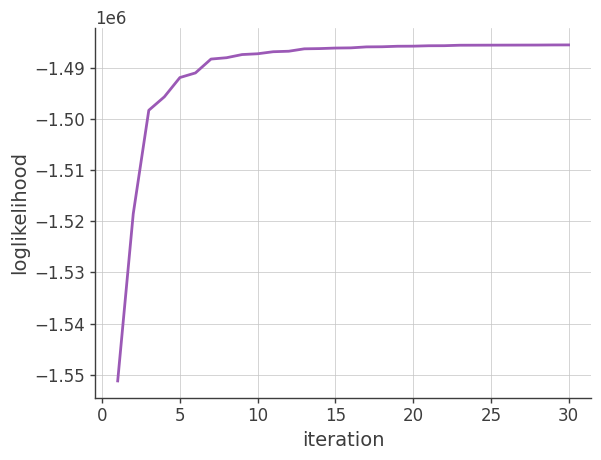

In [17]:
x, y = [], []

for result in all_results:
    x.append(result['iteration'])
    y.append(result['loglikelihood'])
    
plt.plot(x, y)
plt.grid()
plt.xlabel("iteration")
plt.ylabel("loglikelihood")
plt.show()

### Alpha (the factor used for the acceleration)

Plotting $\alpha$ vs the number of iterations. $\alpha$ is a parameter to accelerate the EM algorithm (see the beginning of Section 4). If it is too large, reconstructed images may have artifacts.

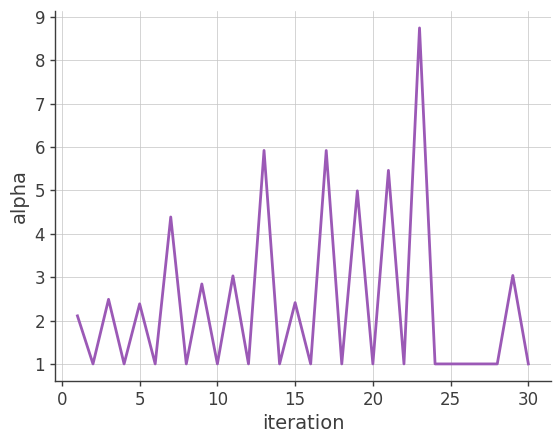

In [18]:
x, y = [], []

for result in all_results:
    x.append(result['iteration'])
    y.append(result['alpha'])
    
plt.plot(x, y)
plt.grid()
plt.xlabel("iteration")
plt.ylabel("alpha")
plt.show()

### Background normalization

Plotting the background nomalization factor vs the number of iterations. If the background model is accurate and the image is reconstructed perfectly, this factor should be close to 1.

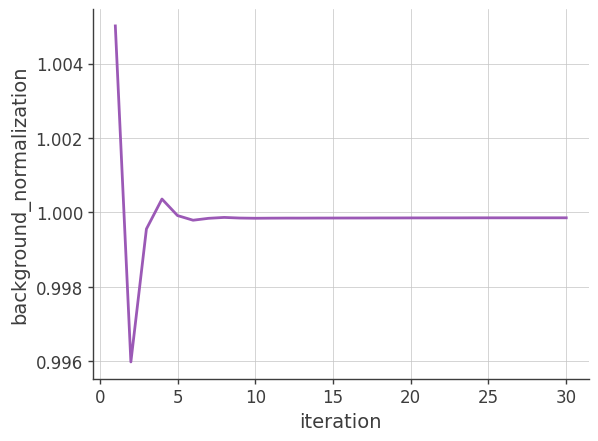

In [19]:
x, y = [], []

for result in all_results:
    x.append(result['iteration'])
    y.append(result['background_normalization'])
    
plt.plot(x, y)
plt.grid()
plt.xlabel("iteration")
plt.ylabel("background_normalization")
plt.show()

### The reconstructed images

In [20]:
def plot_reconstructed_image(result, source_position = None): # source_position should be (l,b) in degrees
    iteration = result['iteration']
    image = result['model_map']

    for energy_index in range(image.axes['Ei'].nbins):
        map_healpxmap = HealpixMap(data = image[:,energy_index], unit = image.unit)

        _, ax = map_healpxmap.plot('mollview')        
        
        _.colorbar.set_label(str(image.unit))
        
        if source_position is not None:
            ax.scatter(source_position[0]*u.deg, source_position[1]*u.deg, transform=ax.get_transform('world'), color = 'red')

        plt.title(label = f"iteration = {iteration}, energy_index = {energy_index} ({image.axes['Ei'].bounds[energy_index][0]}-{image.axes['Ei'].bounds[energy_index][1]})")

Plotting the reconstructed images in all of the energy bands at the 20th iteration

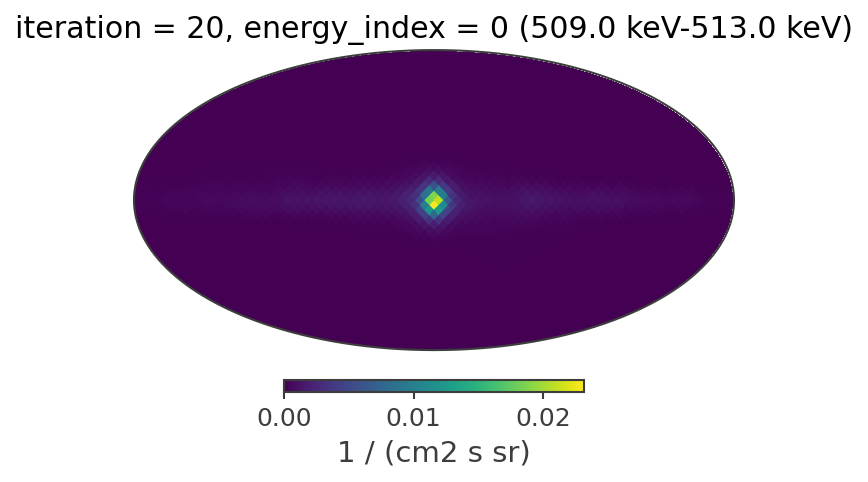

In [21]:
iteration = 19

plot_reconstructed_image(all_results[iteration])

An example to plot the image in the log scale

total flux : 0.00264892824004895 1 / (cm2 s)


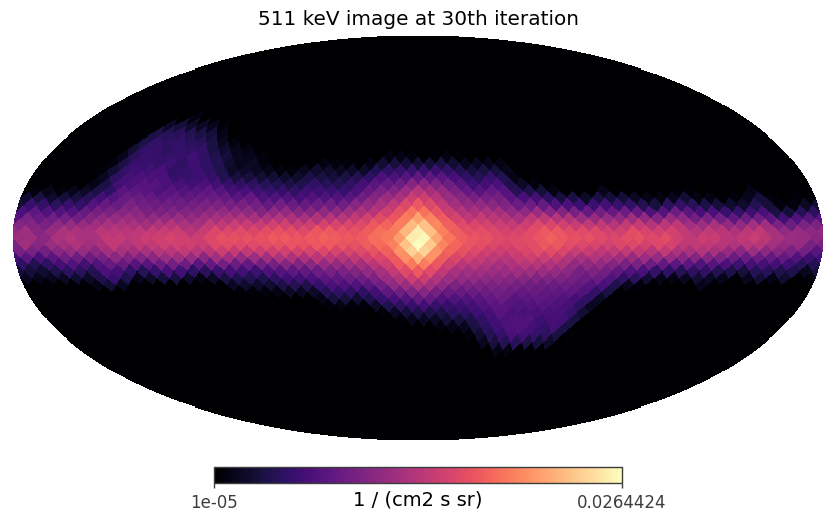

In [35]:
iteration_idx = 29

result = all_results[iteration_idx]

iteration = result['iteration']
image = result['model_map']

print("total flux :", np.sum(image[:,0]) * image.axes['lb'].pixarea())

data = image[:,0]
data[data <= 0 * data.unit] = 1e-12 * data.unit

hp.mollview(data, min = 1e-5, norm ='log', unit = str(data.unit), title = f'511 keV image at {iteration}th iteration', cmap = 'magma')

plt.show()